In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# setting plot size
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run ./feature_engineering.py
%run ./utils.py
%run ./portfolio.py
%run ./perf.py

# 1. ALL DATA

## 1.0. IMPORTING/CLEANING DATA

Importing data from the data folder.

In [3]:
import os

start = time.time()

# get the list of all the files in the data folder
tickers = os.listdir("/Users/edouardcuny/Desktop/quant/Carmela/data2/")
l = []
# iterate through the files and build those who have csv in their name
for ticker in tickers:
    if 'csv' in ticker:
        df = build_df(ticker)
        l.append(df)

AC - dropped NA : 4653 >> 4613
ACA - dropped NA : 4144 >> 4120
AI - dropped NA : 4653 >> 4616
AIR - dropped NA : 4218 >> 4187
ATO - dropped NA : 4653 >> 4614
BN - dropped NA : 7513 >> 6585
BNP - dropped NA : 6273 >> 5773
CA - dropped NA : 4653 >> 4616


/Users/edouardcuny/Desktop/quant/Carmela/feature_engineering.py:253: RuntimeWarning: Mean of empty slice.
  fup = lambda x : x[x>0].mean()


CAP - dropped NA : 4653 >> 4608
DG - dropped NA : 4653 >> 4613
EI - dropped NA : 4653 >> 4600


/Users/edouardcuny/Desktop/quant/Carmela/feature_engineering.py:254: RuntimeWarning: Mean of empty slice.
  fdown = lambda x : np.abs(x[x<0].mean())


EN - dropped NA : 6998 >> 6625
ENGI - dropped NA : 4653 >> 4447
FP - dropped NA : 4653 >> 4613
FR - dropped NA : 4652 >> 2231
GLE - dropped NA : 4653 >> 4615
KER - dropped NA : 4653 >> 4483
LHN - dropped NA : 656 >> 656
LR - dropped NA : 3019 >> 3016
MC - dropped NA : 4653 >> 4609
ML - dropped NA : 4653 >> 4615
OR - dropped NA : 4653 >> 4610
ORA - dropped NA : 4653 >> 4615
SAN - dropped NA : 4653 >> 4607
SGO - dropped NA : 4642 >> 3805
SU - dropped NA : 4653 >> 4614
SW - dropped NA : 22 >> 22
UG - dropped NA : 4653 >> 4610
VIE - dropped NA : 4510 >> 4471
VIV - dropped NA : 4653 >> 4614


Conctenating and cleaning the data.

In [4]:
# concatenation
df = pd.concat(l, axis=0)
# df.to_csv("/Users/edouardcuny/Desktop/stocks.csv") 

# removing rows w/ infinite 
df.replace([np.inf, -np.inf], np.nan,inplace=True)

# removing rows w/ NaN 
df.dropna(inplace=True)

stop = time.time()
print
print 'temps de création du DataFrame : ' + str(round(stop - start))


temps de création du DataFrame : 84.0


## 1.1. ML

- Splitting Train & Test 
- We also do a copy of X_test for the backtesting. Basically for the backtesting we need a DataFrame on which we can do the ML (same columns as X_Train + same rescaling) and also a column with the Ticker and a column with the Adjusted Close. The easiest way to do so is to take X_test before we delete the Ticker and Adjusted Close columns.

In [62]:
X_train,X_test,Y_train,Y_test = split_train_test(df,date="2014-12-31")

# useful later 
df_backtest = X_test.copy()

dropped extreme values : 126954 >> 126954
dropped NA : 126954 >> 126954


We drop useless columns for machine learning.

In [63]:
to_drop = []
to_drop.append('rolling_mean')
to_drop.append('Adj Close')
to_drop.append('vol_rolling_mean')
to_drop.append('Ticker')

X_train.drop(to_drop,axis=1,inplace=True)
X_test.drop(to_drop,axis=1,inplace=True)

- import the model from sklearn
- train
- predict on X_test

In [64]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=7)
clf.fit(X_train,Y_train)
Y_pred = pd.Series(clf.predict(X_test))
Y_pred.index = Y_test.index

## 1.2. RESULTS

In [65]:
# print len(Y_test[Y_test!=0])
# print len(Y_test)
# print np.float64(len(Y_test[Y_test!=0]))/len(Y_test)
# print
# print len(Y_pred[Y_pred!=0])
# print len(Y_pred)
# print np.float64(len(Y_pred[Y_pred!=0]))/len(Y_pred)

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

# print
print 'accuracy : ' + str(accuracy_score(Y_test,Y_pred))


accuracy : 0.434691696483


# 2. VS BENCHMARK

visual check that the stocks we chose on the period do not have anything too strange (like Sanofi for instance where there are very important spikes)

In [66]:
# visual_check(df_backtest)

- we remove all the info about the stocks that we didn't select
- pf has one column per ticker and adj close as rows

In [67]:
pf = build_portfolio(df_backtest)


['AI', 'SU', 'FP', 'BNP', 'DG', 'OR', 'VIE', 'BN', 'GLE', 'MC', 'VIV', 'AIR']


We are going to compare our algorithm to :
- BHW : a strategy where we buy each stock on our list on day one w/ the same weight as their adjusted close and we hold
- BHNW : a strategy where we buy each stock on our list w/ no weights
- CAC40

In [79]:
# BUY & HOLD WEIGHTS
allocation = pf.iloc[0,:]/pf.iloc[0,:].sum()
funds = 1000
bhw = portfolio_evolution(allocation,funds,pf)

# BUY & HOLD NO WEIGHTS
alloc = 1./pf.shape[1]*np.ones([pf.shape[0],pf.shape[1]])
bhnw = portfolio_evo_moving_alloc(alloc,1000,pf)

In [80]:
%run ./portfolio.py
# CARMELA
df_backtest['pred'] = Y_pred
pred = build_pred(df_backtest)
alloc = build_alloc(pred)
carm = portfolio_evo_moving_alloc(alloc,1000,pf)


['AI', 'SU', 'FP', 'BNP', 'DG', 'OR', 'VIE', 'BN', 'GLE', 'MC', 'VIV', 'AIR']


In [81]:
# CAC40
cac = pd.read_csv('/Users/edouardcuny/Desktop/quant/Carmela/CAC40.csv',index_col='Date',dtype={'Adj Close': np.float64},na_values=['null',0])
cac.dropna(inplace=True)
bhw = bhw.join(cac['Adj Close'], rsuffix = 'CAC40')
bhw.iloc[:,-1]=bhw.iloc[:,-1]/bhw.iloc[0,-1]*1000

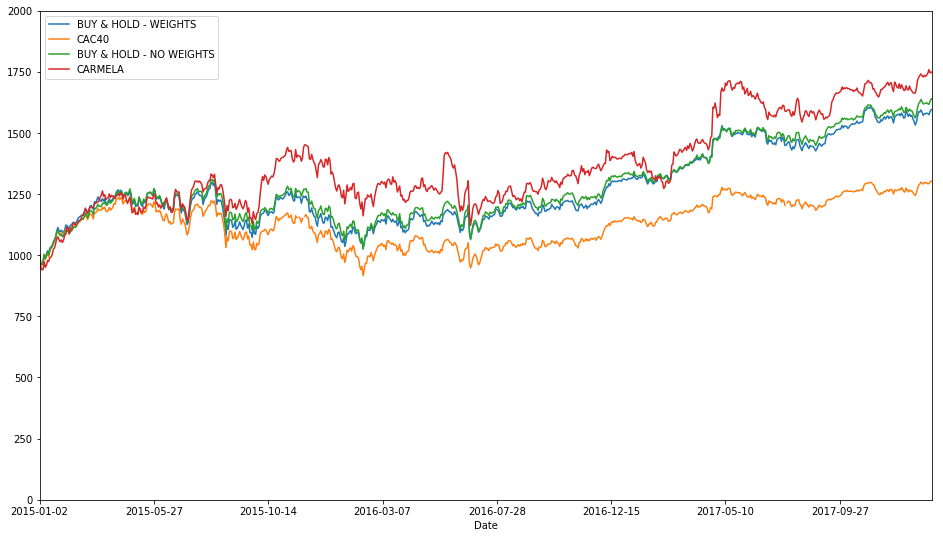

In [82]:
# plot
bhw['TOTAL'].plot(label='BUY & HOLD - WEIGHTS')
bhw['Adj CloseCAC40'].plot(label='CAC40')
bhnw['TOTAL'].plot(label='BUY & HOLD - NO WEIGHTS')
carm['TOTAL'].plot(label='CARMELA')
plt.legend()
axes = plt.gca()
axes.set_ylim([0,2000])
plt.show()

# 3. EVALUATING THE PERFORMANCE

In [84]:
print 'SHARPE'
print 'CARMELA : ', sharpe(carm['TOTAL'])
print 'BHNW    : ', sharpe(bhnw['TOTAL'])
print 'BHW     : ', sharpe(bhw['TOTAL'])
print 'CAC     : ', sharpe(bhw['Adj CloseCAC40'])

print 
print 'MONTHLY MAX DRAWDOWN'
print 'CARMELA : ', rolling_max_drawdown(carm['TOTAL'],20),'%'
print 'BHNW    : ', rolling_max_drawdown(bhnw['TOTAL'],20),'%'
print 'BHW     : ', rolling_max_drawdown(bhw['TOTAL'],20),'%'
print 'CAC     : ', rolling_max_drawdown(bhw['Adj CloseCAC40'],20),'%'

print 
print 'ANNUAL RETURN'
print 
print 'CARMELA'
print_d(annual_return(carm['TOTAL']))
print 'BHNW   '
print_d(annual_return(bhnw['TOTAL']))
print 'BHW     '
print_d(annual_return(bhw['TOTAL']))
print 'CAC     '
print_d(annual_return(bhw['Adj CloseCAC40']))


SHARPE
CARMELA :  0.881
BHNW    :  0.939
BHW     :  0.892
CAC     :  0.525

MONTHLY MAX DRAWDOWN
CARMELA :  -20.28 %
BHNW    :  -15.74 %
BHW     :  -16.86 %
CAC     :  -15.65 %

ANNUAL RETURN

CARMELA
2015 39%
2016 5%
2017 18%
2018 5%

BHNW   
2015 19%
2016 15%
2017 18%
2018 5%

BHW     
2015 16%
2016 18%
2017 18%
2018 4%

CAC     
2015 10%
2016 8%
2017 9%
2018 5%



In [5]:
df.head()

,Ticker,Adj Close,in_BB,pr_in_BB,out_to_in_BB,rolling_mean,spike,pr_spike,spike_derivative,crossed_RM_up,...,macad,pr_macad,macad_derivative,Kfast,Dfast,Dslow,LWR,CMF,SMI,y
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-08,AC,4.239109,1.0,1.0,0.0,4.461310,0.950194,0.949293,0.000901,0.0,...,0.031507,0.025933,0.005574,6.896759,6.535668,8.803374,93.103241,-0.453209,-38.991367,1.0
2000-02-09,AC,4.519144,1.0,1.0,0.0,4.464604,1.012216,0.950194,0.062022,1.0,...,0.033084,0.031507,0.001577,54.628800,23.609008,12.427154,45.371200,-0.397813,-38.716805,-1.0
2000-02-10,AC,4.814561,1.0,1.0,0.0,4.495445,1.070986,1.012216,0.058770,0.0,...,0.007907,0.033084,-0.025176,98.085039,53.203533,27.782736,1.914961,-0.292978,-38.569207,-1.0
2000-02-11,AC,4.777222,1.0,1.0,0.0,4.519057,1.057128,1.070986,-0.013858,0.0,...,-0.033963,0.007907,-0.041870,92.172174,81.628671,52.813737,7.827826,-0.274165,-37.912713,-1.0
2000-02-14,AC,4.722322,1.0,1.0,0.0,4.543767,1.039297,1.057128,-0.017831,0.0,...,-0.057479,-0.033963,-0.023517,82.903238,91.053484,75.295229,17.096762,-0.271661,-36.244834,-1.0
